In [3]:
from folktables import ACSDataSource, ACSEmployment

data_source = ACSDataSource(survey_year='2016', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)
sex = features[:, -2]
old = (features[:,0] > 65)

In [4]:
import numpy as np

In [5]:
group_names = []
group_memberships = []
group_memberships.append([True] * label.shape[0])
group_names.append('ALL')
for g in np.unique(group):
    if g == 4 or g == 5: # group is too small
        continue
    group_memberships.append(group == g)
    group_names.append('R{0}'.format(g))
group_memberships.append(sex == 1)
group_names.append('S1')
group_memberships.append(sex == 2)
group_names.append('S2')
group_memberships.append(old == False)
group_names.append('A1')
group_memberships.append(old == True)
group_names.append('A2')
num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 12


In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
to_one_hot = set(['MAR', 'RELP', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'DREM', 'RAC1P'])
to_leave_alone = set(ACSEmployment.features) - to_one_hot
one_hot_inds = [i for i, x in enumerate(ACSEmployment.features) if x in to_one_hot]
leave_alone_inds = [i for i, x in enumerate(ACSEmployment.features) if x in to_leave_alone]

steps = [('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_inds), ('num', 'passthrough', leave_alone_inds)]
ct = ColumnTransformer(steps)
features_t = ct.fit_transform(features).toarray()

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [8]:
# do train-test split
splits = train_test_split(*tuple([features_t, label] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]
group_train = splits[4::2]
group_test = splits[5::2]

In [7]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.44420067280971187
P(Y=1 | group 1) = 0.44883404292105206
P(Y=1 | group 2) = 0.38847780126849896
P(Y=1 | group 3) = 0.3307543520309478
P(Y=1 | group 4) = 0.47728665207877463
P(Y=1 | group 5) = 0.4642857142857143
P(Y=1 | group 6) = 0.44298006753077007
P(Y=1 | group 7) = 0.3571027512633352
P(Y=1 | group 8) = 0.4840593818447311
P(Y=1 | group 9) = 0.4056401402186993
P(Y=1 | group 10) = 0.49899034517574303
P(Y=1 | group 11) = 0.15035112953718588


In [8]:
num_group_train = {}
num_group_test = {}
print('Group\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group	train	test
0 (ALL)	300828	75207
1 (R1)	184961	46271
2 (R2)	15047	3784
3 (R3)	2080	517
4 (R6)	45385	11425
5 (R7)	1057	280
6 (R8)	37135	9181
7 (R9)	14416	3562
8 (S1)	148622	36981
9 (S2)	152206	38226
10 (A1)	254184	63388
11 (A2)	46644	11819


In [9]:
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)
rf_yhat = rf_model.predict(X_test)
rf_test_err = {}
for g in range(num_groups):
    rf_test_err[g] = np.mean(y_test[group_test[g]] != rf_yhat[group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,rf_test_err[g],np.sqrt(2. * rf_test_err[g] * (1.0 - rf_test_err[g]) / num_group_test[g]), num_group_test[g], group_names[g]))


group 0 (ALL): 0.20572553086813727 (+/-0.002084564140691902; n=75207)
group 1 (R1): 0.2076030342979404 (+/-0.0026665443140384696; n=46271)
group 2 (R2): 0.20718816067653276 (+/-0.009317662271578231; n=3784)
group 3 (R3): 0.21470019342359767 (+/-0.025538988313010724; n=517)
group 4 (R6): 0.21234135667396062 (+/-0.005410946113346945; n=11425)
group 5 (R7): 0.22857142857142856 (+/-0.03548908590903536; n=280)
group 6 (R8): 0.19681951857096178 (+/-0.00586827772996953; n=9181)
group 7 (R9): 0.17546322290847838 (+/-0.009012932261979934; n=3562)
group 8 (S1): 0.17287255617749656 (+/-0.0027808330397407657; n=36981)
group 9 (S2): 0.2375085020666562 (+/-0.0030781703682587537; n=38226)
group 10 (A1): 0.2117119959613807 (+/-0.0022947039610653024; n=63388)
group 11 (A2): 0.17361874947119046 (+/-0.004927347262521457; n=11819)


In [10]:
models = {}
yhats = {}
test_err = {}
for g in range(num_groups):
    models[g] = make_pipeline(StandardScaler(), LogisticRegressionCV(cv=3, max_iter=500))
    #models[g] = DecisionTreeClassifier(random_state=0)
    #models[g] = RandomForestClassifier(random_state=0)
    models[g].fit(X_train[group_train[g],:], y_train[group_train[g]])
    yhats[g] = models[g].predict(X_test)
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g],np.sqrt(2. * test_err[g] * (1.0 - test_err[g]) / num_group_test[g]), num_group_test[g], group_names[g]))


group 0 (ALL): 0.2092092491390429 (+/-0.0020975247607032325; n=75207)
group 1 (R1): 0.20552830066348252 (+/-0.002656657612160973; n=46271)
group 2 (R2): 0.21062367864693446 (+/-0.00937421863241817; n=3784)
group 3 (R3): 0.25918762088974856 (+/-0.0272540450437482; n=517)
group 4 (R6): 0.23518599562363238 (+/-0.005611391088619291; n=11425)
group 5 (R7): 0.225 (+/-0.03529214805428701; n=280)
group 6 (R8): 0.20694913408125476 (+/-0.005979327382664772; n=9181)
group 7 (R9): 0.16591802358225716 (+/-0.008814936568124834; n=3562)
group 8 (S1): 0.17438684729996484 (+/-0.0027904281027189668; n=36981)
group 9 (S2): 0.23787474493800032 (+/-0.003079802836273228; n=38226)
group 10 (A1): 0.20434467091563072 (+/-0.002264934355005916; n=63388)
group 11 (A2): 0.15009730095608764 (+/-0.004646176214296712; n=11819)


In [11]:
erm_test_err = {}
for g in range(num_groups):
    erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, erm_test_err[g], np.sqrt(2. * erm_test_err[g] * (1.0 - erm_test_err[g]) / num_group_test[g]), num_group_test[g], group_names[g]))


group 0 (ALL): 0.2092092491390429 (+/-0.0020975247607032325; n=75207)
group 1 (R1): 0.20701951546324912 (+/-0.0026637744478038477; n=46271)
group 2 (R2): 0.20824524312896406 (+/-0.009335171898683593; n=3784)
group 3 (R3): 0.24564796905222436 (+/-0.026774005433165417; n=517)
group 4 (R6): 0.2336105032822757 (+/-0.005598321662197656; n=11425)
group 5 (R7): 0.21428571428571427 (+/-0.0346788683019723; n=280)
group 6 (R8): 0.2046618015466725 (+/-0.005954760804684523; n=9181)
group 7 (R9): 0.16423357664233576 (+/-0.008778927763765683; n=3562)
group 8 (S1): 0.17798328871582705 (+/-0.002812908526200815; n=36981)
group 9 (S2): 0.2394181970386648 (+/-0.003086648055845878; n=38226)
group 10 (A1): 0.21300561620495992 (+/-0.0022998145484955106; n=63388)
group 11 (A2): 0.18884846433708435 (+/-0.0050913430182538124; n=11819)


In [12]:
f = [0]
#epsilon = 0.01
epsilon = 0

H_train = {}
H_test = {}
H_train_err = {}
for g in range(num_groups):
    H_train[g] = models[g].predict(X_train)
    H_test[g] = models[g].predict(X_test)
    H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
F_train = H_train[0].copy()
F_test = H_test[0].copy()
F_train_err = {}
for g in range(num_groups):
    F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
while True:
    #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
    scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
    g = np.argmin(scores)
    if scores[g] < 0.:
        f.insert(0,g) # prepend g to the list f
        F_train[group_train[g]] = H_train[g][group_train[g]]
        F_test[group_test[g]] = H_test[g][group_test[g]]
        for g in range(num_groups):
            F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    else:
        break

print([group_names[g] for g in f])

['A2', 'R3', 'R7', 'A1', 'R3', 'R7', 'A2', 'ALL']


In [13]:
F_test_err = {}
for g in range(num_groups):
    F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], np.sqrt(2. * F_test_err[g] * (1.0 - F_test_err[g]) / num_group_test[g]), num_group_test[g], group_names[g]))


group 0 (ALL): 0.19588602124802212 (+/-0.0020466632614756708; n=75207)
group 1 (R1): 0.1941604892913488 (+/-0.002600550325446569; n=46271)
group 2 (R2): 0.2005813953488372 (+/-0.009206019356000758; n=3784)
group 3 (R3): 0.2437137330754352 (+/-0.026702555994832032; n=517)
group 4 (R6): 0.21120350109409192 (+/-0.005400325498248732; n=11425)
group 5 (R7): 0.22142857142857142 (+/-0.03509150886139118; n=280)
group 6 (R8): 0.19627491558653742 (+/-0.005862139718748928; n=9181)
group 7 (R9): 0.15384615384615385 (+/-0.008549407707349696; n=3562)
group 8 (S1): 0.16292150022984775 (+/-0.0027158011407033508; n=36981)
group 9 (S2): 0.22777690577094126 (+/-0.0030336243901873637; n=38226)
group 10 (A1): 0.20442355019877578 (+/-0.002265259163154952; n=63388)
group 11 (A2): 0.15009730095608764 (+/-0.004646176214296712; n=11819)


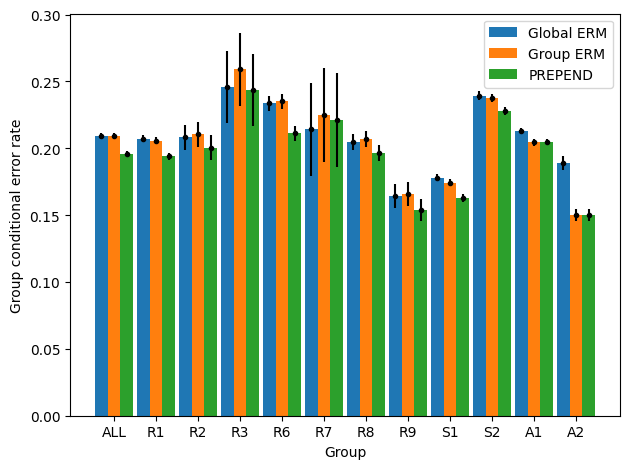

In [14]:
import matplotlib.pyplot as plt
plot_group_labels = group_names
plot_x = np.arange(num_groups)
bar_width = 0.3
fig, ax = plt.subplots()
plot_rects1 = ax.bar(plot_x - bar_width, [erm_test_err[g] for g in range(num_groups)], bar_width, label='Global ERM')
plot_rects2 = ax.bar(plot_x, [test_err[g] for g in range(num_groups)], bar_width, label='Group ERM')
plot_rects3 = ax.bar(plot_x + bar_width, [F_test_err[g] for g in range(num_groups)], bar_width, label='PREPEND')
plot_err1 = ax.errorbar(plot_x - bar_width, [erm_test_err[g] for g in range(num_groups)], [np.sqrt(2. * erm_test_err[g] * (1.0 - erm_test_err[g]) / num_group_test[g]) for g in range(num_groups)], fmt='.', color='Black')
plot_err2 = ax.errorbar(plot_x, [test_err[g] for g in range(num_groups)], [np.sqrt(2. * test_err[g] * (1.0 - test_err[g]) / num_group_test[g]) for g in range(num_groups)], fmt='.', color='Black')
plot_err3 = ax.errorbar(plot_x + bar_width, [F_test_err[g] for g in range(num_groups)], [np.sqrt(2. * F_test_err[g] * (1.0 - F_test_err[g]) / num_group_test[g]) for g in range(num_groups)], fmt='.', color='Black')
ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
ax.legend()

fig.tight_layout()

#plt.savefig('employment_prediction_ca.pdf')
#plt.savefig('employment_prediction_ca.png')
plt.show()

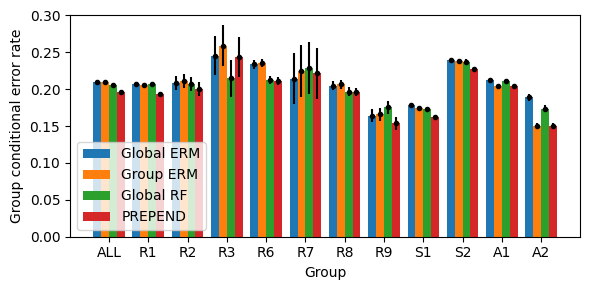

In [28]:
import matplotlib.pyplot as plt
plot_group_labels = group_names
plot_x = np.arange(num_groups)
bar_width = 0.2
fig, ax = plt.subplots()
plot_rects1 = ax.bar(plot_x - 1.5*bar_width, [erm_test_err[g] for g in range(num_groups)], bar_width, label='Global ERM')
plot_rects2 = ax.bar(plot_x - 0.5*bar_width, [test_err[g] for g in range(num_groups)], bar_width, label='Group ERM')
plot_rects4 = ax.bar(plot_x + 0.5*bar_width, [rf_test_err[g] for g in range(num_groups)], bar_width, label='Global RF')
plot_rects3 = ax.bar(plot_x + 1.5*bar_width, [F_test_err[g] for g in range(num_groups)], bar_width, label='PREPEND')
plot_err1 = ax.errorbar(plot_x - 1.5*bar_width, [erm_test_err[g] for g in range(num_groups)], [np.sqrt(2. * erm_test_err[g] * (1.0 - erm_test_err[g]) / num_group_test[g]) for g in range(num_groups)], fmt='.', color='Black')
plot_err2 = ax.errorbar(plot_x - 0.5*bar_width, [test_err[g] for g in range(num_groups)], [np.sqrt(2. * test_err[g] * (1.0 - test_err[g]) / num_group_test[g]) for g in range(num_groups)], fmt='.', color='Black')
plot_err4 = ax.errorbar(plot_x + 0.5*bar_width, [rf_test_err[g] for g in range(num_groups)], [np.sqrt(2. * rf_test_err[g] * (1.0 - rf_test_err[g]) / num_group_test[g]) for g in range(num_groups)], fmt='.', color='Black')
plot_err3 = ax.errorbar(plot_x + 1.5*bar_width, [F_test_err[g] for g in range(num_groups)], [np.sqrt(2. * F_test_err[g] * (1.0 - F_test_err[g]) / num_group_test[g]) for g in range(num_groups)], fmt='.', color='Black')
ax.set_ylabel('Group conditional error rate')
ax.set_xlabel('Group')
ax.set_xticks(plot_x, plot_group_labels)
ax.legend(loc='lower left')
fig.set_size_inches(6., 3.)
fig.tight_layout()

plt.savefig('employment_prediction_ca2.pdf')
#plt.savefig('employment_prediction_ca2.png')
plt.show()

In [16]:
#sorted_indices = np.argsort(np.abs(models[0][1].coef_[0,:]))
#np.column_stack((models[0][1].coef_[0,sorted_indices],ct.get_feature_names_out()[sorted_indices]))